### Machine Learning Aplicado à Propensão a Inovar das Empresas Latinoamericanas
Andrew da Costa Marques, Tatiana Escovedo


A inovação é o motor do desenvolvimento econômico, social e sustentável dos países, mobilizando significativos recursos dos setores privado e público, incluindo diferentes mecanismos de apoio governamental à inovação, tais como incentivos fiscais e linhas especiais de crédito. Este trabalho objetiva a construção de modelo acerca da propensão de uma empresa inovar, o que pode contribuir para o aperfeiçoamento da execução de políticas públicas relacionadas à promoção da inovação. Para tanto, foram aplicadas técnicas de machine learning em dados coletados entre 2007 e 2017 de cinco países da América do Sul mais assemelhados ao cenário brasileiro disponíveis no Harmonized Latin American Innovation Surveys Database - Argentina, Chile, Colômbia, Peru e Uruguai, considerando variados algoritmos de aprendizado supervisionado - LightGBM, Random Forest, Ridge, Support Vector Machines (SVM) e K-Nearest Neighbors (KNN). Com base nos experimentos realizados, foi construído modelo com 84% de precisão quanto à introdução de inovação por uma empresa, resultado que sofre ligeiras variações por setor econômico e país, mas preserva razoável capacidade preditiva, tendo sido identificadas as principais features do modelo. Considerando somente inovações com impacto no mercado, país ou mundo, ignorando as inovações restritas ao escopo da própria firma, foi construído modelo com 96% de precisão quanto às empresas que não conseguiriam inovar. A utilização de dados de diferentes países e períodos colabora para a construção de modelo preditivo que considere os aspectos mais transversais da inovação na região, a despeito das particularidades nacionais. Os resultados alcançados neste estudo parecem suficientemente animadores para encorajar novos trabalhos que objetivem a construção de modelos semelhantes parametrizados conforme a realidade brasileira e que possam colaborar para a ampliação da taxa de inovação no país e, em última instância, para o fortalecimento do Sistema Nacional de Inovação. 


In [ ]:
!pip install pycaret

In [2]:
# Imports
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pycaret
from sklearn.metrics import precision_score,recall_score,f1_score

np.random.seed(42) #seed global


%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
pd.set_option("display.max_columns", None) #sem limite de colunas mostradas pelo pandas

### CARGA

Em virtude da dimensionalidade do *dataset* completo, foi feita uma filtragem manual dos atributos a fim de manter apenas aqueles relevantes e logicamente precedentes à introdução da inovação. 

Foram desconsideradas, por exemplo, questões relacionadas a patentes, pois poderiam induzir a um vazamento de informações sobre o alvo (*data leakage*). Pela mesma razão, foi desconsiderada a variável indicadora de projetos de inovação abandonados (*dabandia*). Outras variáveis foram ignoradas pela redundância de informações, como a indicadora de atividades de inovação em progresso (*dongoingia*). 


In [8]:

features = {'country': 'str','exp_f': 'float','year': 'int',
            'isic3_1d': 'str','sales_us_Y1': 'float','sales_us_Y2': 'float',
            'sales_us_Y3': 'float','export_us_Y1': 'float','export_us_Y2': 'float','export_us_Y3': 'float',
            'dexport': 'bool','empl_Y1': 'int','empl_Y2': 'int','empl_Y3': 'int',
            'phd_Y1': 'float','phd_Y2': 'float','phd_Y3': 'float','master_Y1': 'float','master_Y2': 'float','master_Y3': 'float',
            'postgrad_Y1': 'float','postgrad_Y2': 'float','postgrad_Y3': 'float','undergrad_Y1': 'float',
            'undergrad_Y2': 'float','undergrad_Y3': 'float','unidegree_Y1': 'float','unidegree_Y2': 'float','unidegree_Y3': 'float',
            'degree_nesc': 'float','degree_et': 'float','degree_ingnesc': 'float','degree_ssc': 'float','degree_medsc': 'float',
            'degree_agrsc': 'float','degree_hum': 'float','nontert_Y1': 'float','nontert_Y2': 'float','nontert_Y3': 'float',
            'second_Y1': 'float','second_Y2': 'float','second_Y3': 'float','RD_empl': 'int','ict_mach_us_Y1': 'float',
            'IPexp_us_Y1': 'float','ict_mach_us_Y2': 'float','IPexp_us_Y2': 'float','drdintexp': 'int','drdextexp': 'float','dictexp': 'float',
            'dmachexp': 'float','dict_mach': 'int','dTTexp': 'int','dconexp': 'int','dIPexp': 'int','dtrainexp': 'int',
            'dIDexp': 'int','dmktexp': 'int','dinnpd': 'int','dinnpc': 'int','innpd_scp':'int','innpc_scp':'int'
}

df_og = pd.read_csv('./data/raw/LAIS_public.csv', usecols=features.keys())



A LAIS não apresenta dados oriundos do Brasil. Não se ignora, contudo, que a inovação é influenciada, em cada país, pelas suas particularidades socioeconômicas, culturais e políticas e pelo contexto institucional.

Buscando a criação de um modelo mais aderente à realidade brasileira, foram selecionados os cinco países da América do Sul incluídos na LAIS (presumindo serem mais semelhantes ao Brasil do que países da América Central) que obtiveram notas mais próximas àquelas atribuídas ao Brasil considerando cada uma das 14 edições do Global Innovation Index, publicadas entre 2007 e 2021, quais sejam: Argentina, Colômbia, Peru, Uruguai e Chile. Estes países são os mesmos da América do Sul selecionados pela Confederação Nacional da Indústria no relatório “Competitividade Brasil”, com exceção do Uruguai. Portanto, dos países da América do Sul com dados na LAIS, não foram considerados o Paraguai e o Equador.

Estes tratamentos combinados resultaram em um dataset intermediário com 107.280 linhas e 62 colunas.

In [4]:
#filtragem dos países
countries = ['Argentina','Colombia','Uruguay','Peru','Chile']
df_og = df_og.query('country in @countries')

#dimensões do dataset
df_og.shape

(107280, 62)

Em função do problema definido, e tendo em vista o conceito de inovação definido no Manual de Oslo, foi criada a variável dependente a ser prevista - *dinn* - a partir do agrupamento das variáveis *dinnpd* e *dinnpc*, que indicam inovações a nível de produto e a nível de processo, respectivamente.

In [5]:
df_dinn = df_og.copy()

df_dinn['dinn'] = 0
df_dinn.dinnpd = df_dinn.dinnpd.astype('Int32')
df_dinn.dinnpc = df_dinn.dinnpc.astype('Int32')
df_dinn.loc[(df_dinn.dinnpd==1) | (df_dinn.dinnpc==1),'dinn']=1

df_dinn.drop(['dinnpd','dinnpc','innpd_scp', 'innpc_scp'],axis=1,inplace=True)

df_dinn.to_csv('./data/processed/dinn_dataset.csv',index=False)


Uma vez que a atuação governamental pode buscar fomentar inovações com maior impacto para o mercado, foi definida variável dependente alternativa, que trata do escopo / alcance da inovação - nacional / internacional ou só para a firma.

Assim, foi criada a variável *dinn_scp*, que é a união das variáveis *innpd_scp* e *innpc_scp*, indicadoras do escopo da inovação de produto ou processo. Estas variáveis se aplicam apenas a firmas que inovaram no período referencial e admitem quatro valores: *firm, market, country, world*. Para os três últimos valores, a *dinn_scp* assume o valor 1, enquanto assume o valor 0 para *firm* e em instâncias nulas (não houve inovação). 


In [6]:
df_dinnscp = df_og.copy()
df_dinnscp.replace({'innpd_scp':['Country','World','Market'], 'innpc_scp':['Country','World','Market']},1,inplace=True)
df_dinnscp.replace({'innpd_scp':['Firm',np.nan], 'innpc_scp':['Firm',np.nan]},0,inplace=True)
df_dinnscp['dinn_scp'] = df_dinnscp['innpd_scp'] + df_dinnscp['innpc_scp']
df_dinnscp.replace({'dinn_scp':2},1,inplace=True)

df_dinnscp.drop(['innpd_scp','innpc_scp'],axis=1,inplace=True)

df_dinnscp.to_csv('./data/processed/dinn_scp_dataset.csv',index=False)

### Análise de Dados

Optou-se pela utilização dos dados constantes na LAIS de todas as edições de pesquisa - 2007 a 2017. Buscou-se, assim, mitigar o eventual efeito nos dados da conjuntura socioeconômica dos países selecionados em cada momento de coleta dos dados da LAIS.

Em se tratando de horizonte temporal extenso, é importante verificar o comportamento das features ao longo do tempo, tendo em vista as mudanças no ambiente da inovação ocorridas no período. Para tanto, foi analisada a correlação de Pearson das features com a variável dependente. De modo geral, observa-se que não foram identificadas discrepâncias importantes, dado que a correlação das features com inovação permaneceu relativamente estável, de tal sorte que a variável year foi desconsiderada.

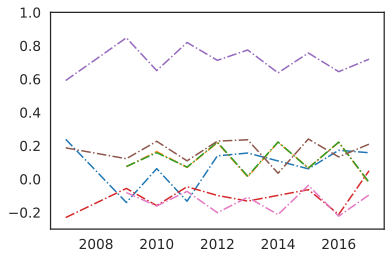

In [7]:
corrs = {}
sns.set_context("notebook", font_scale=1.25)
sns.set_style('white')
for year in set(df_dinn.year):
    corrs[year] = df_dinn.query('year==@year').corr()['dinn'].sort_values(ascending=False)
corr_por_ano = pd.concat(corrs.values(),axis=1)
corr_por_ano.columns = corrs.keys()
corr_por_ano = corr_por_ano[corr_por_ano.columns.sort_values()]
mais_variaveis = corr_por_ano.assign(var = corr_por_ano.var(axis=1)).nlargest(7,columns='var').drop(columns=['var'])
for i in mais_variaveis.index:
    sns.lineplot(mais_variaveis.columns,mais_variaveis.loc[i,:], linestyle='dashdot')
    plt.ylim([-0.3, 1])
    plt.ylabel(None)
    #plt.show()

In [ ]:
#tipos das colunas
df_dinn.info()

In [105]:
#estatisticas descritivas do dataset
df_dinn.describe()

,exp_f,year,sales_us_Y1,sales_us_Y2,sales_us_Y3,export_us_Y1,export_us_Y2,export_us_Y3,dexport,empl_Y1,empl_Y2,empl_Y3,phd_Y1,phd_Y2,phd_Y3,master_Y1,master_Y2,master_Y3,postgrad_Y1,postgrad_Y2,postgrad_Y3,undergrad_Y1,undergrad_Y2,undergrad_Y3,unidegree_Y1,unidegree_Y2,unidegree_Y3,degree_nesc,degree_et,degree_ingnesc,degree_ssc,degree_medsc,degree_agrsc,degree_hum,nontert_Y1,nontert_Y2,nontert_Y3,second_Y1,second_Y2,second_Y3,RD_empl,ict_mach_us_Y1,IPexp_us_Y1,ict_mach_us_Y2,IPexp_us_Y2,drdintexp,drdextexp,dictexp,dmachexp,dict_mach,dTTexp,dconexp,dIPexp,dtrainexp,dIDexp,dmktexp,dinn
count,107280.000000,107280.000000,5.456600e+04,8.230200e+04,1.806300e+04,4.709200e+04,7.482700e+04,1.058900e+04,87292.000000,103513.000000,100939.000000,18165.000000,80227.000000,79924.000000,0.0,80227.000000,79924.000000,0.0,81676.000000,79924.000000,2571.000000,81676.000000,79924.000000,2571.000000,88444.000000,88513.000000,18136.000000,33241.000000,33241.000000,36932.000000,35362.000000,35362.000000,29297.000000,35362.000000,81676.000000,79924.000000,2571.000000,82411.000000,80959.000000,2576.000000,97529.000000,9.662300e+04,7.441100e+04,9.678000e+04,7.441100e+04,107280.000000,107280.000000,83074.000000,83074.000000,107280.000000,99266.000000,72484.000000,80498.000000,107280.000000,99184.000000,95939.000000,107280.000000
mean,8.241454,2013.314485,3.454349e+07,3.103062e+07,1.633257e+07,3.091071e+07,1.957253e+07,4.401059e+06,0.210455,154.205564,154.746666,126.006173,0.127301,0.132475,NaN,2.723824,2.911332,NaN,2.843735,3.043807,2.792477,15.234979,15.605266,15.312170,17.008951,17.459650,10.100189,13.437815,27.880954,21.197738,43.198578,4.480915,2.499499,5.158006,17.257112,17.545445,21.415513,65.294978,64.270837,60.556548,1.388900,1.437448e+05,1.181519e+04,1.915279e+05,1.619813e+04,0.108333,0.037640,0.175205,0.240256,0.270022,0.033959,0.117902,0.119146,0.098145,0.066745,0.072921,0.279521
std,41.956438,2.732973,3.267493e+08,3.458539e+08,9.896933e+07,5.248234e+09,3.866141e+09,2.986826e+07,0.407634,687.825088,627.889148,412.392410,1.784568,1.822541,NaN,7.633283,7.861588,NaN,7.987164,8.252651,6.717615,18.278179,18.447983,15.494246,20.949303,21.122926,15.262465,28.496815,33.585699,31.214087,38.749000,17.139509,11.362613,16.923051,20.161577,20.248191,20.452871,30.281701,30.497512,27.390629,16.190583,3.909799e+06,2.812124e+05,6.765358e+06,4.391070e+05,0.310802,0.190324,0.380145,0.427241,0.443973,0.181125,0.322494,0.323962,0.297512,0.249580,0.260009,0.448766
min,0.600000,2007.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2011.000000,6.238229e+05,5.762189e+05,6.479681e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,14.000000,14.000000,15.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,3.465347,3.703704,5.000000,3.349282,3.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.352941,2.564103,6.400000,48.571428,46.153847,44.444443,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2013.000000,2.396337e+06,2.204100e+06,2.094826e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,36.000000,36.000000,35.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.454545,9.494452,10.000000,11.111111,10.000000,10.344828,4.687500,0.000000,13.425926,3.061224,40.000000,0.000000,0.000000,0.000000,10.714286,11.111111,15.748032,75.000000,74.074074,66.666672,0.000000,0.000000e+00,0.

In [106]:
#representatividade de cada país
df_dinn['country'].value_counts(normalize=True)

Colombia     0.604484
Chile        0.225634
Uruguay      0.074702
Argentina    0.071169
Peru         0.024012
Name: country, dtype: float64

In [107]:
#representatividade das áreas de atuação
df_dinn['isic3_1d'].value_counts(normalize=True)

Manufacturing                                  0.621763
Wholesale and retail trade                     0.101853
Transport, storage, and communications         0.066618
Real state, renting and business activities    0.052409
Hotels and restaurants                         0.036006
Health and social work                         0.033590
Construction                                   0.018467
social and personal services                   0.017513
Agriculture, hunting and forestry              0.013726
Eletricity, gas and water supply               0.012994
Financial Intermediation                       0.009795
Education                                      0.007039
Fishing                                        0.005407
Mining and quarrying                           0.002821
Name: isic3_1d, dtype: float64

In [108]:
#representatividade da váriavel dependente indicadora de inovação
df_dinn['dinn'].value_counts(normalize=True)

0    0.720479
1    0.279521
Name: dinn, dtype: float64

In [109]:
#representatividade da váriavel dependente indicadora de inovação que tenha causado impacto fora da firma
df_dinnscp['dinn_scp'].value_counts(normalize=True)

0.0    0.908249
1.0    0.091751
Name: dinn_scp, dtype: float64

### Tratamentos

Buscamos diminuir a cardinalidade da variável isic3_1d, indicadora do setor de atuação das firmas (semelhante à Classificação Econômica de Atividades Econômicas - CNAE). Das 12 áreas de atuação presentes no dataset, as firmas de varejo e atacado (wholesale and retail trade) e as indústrias de transformação (manufacturing) respondem, respectivamente, por 10% e 62% das instâncias restantes e nenhum outro setor ultrapassou 7% de representatividade. Foram agrupados, então, os dez setores com baixa representatividade, totalizando três categorias mais robustas, o que diminui o risco de overfitting do modelo.

In [110]:
df_dinn['isic3_1d'].value_counts(normalize=True)

Manufacturing                                  0.621763
Wholesale and retail trade                     0.101853
Transport, storage, and communications         0.066618
Real state, renting and business activities    0.052409
Hotels and restaurants                         0.036006
Health and social work                         0.033590
Construction                                   0.018467
social and personal services                   0.017513
Agriculture, hunting and forestry              0.013726
Eletricity, gas and water supply               0.012994
Financial Intermediation                       0.009795
Education                                      0.007039
Fishing                                        0.005407
Mining and quarrying                           0.002821
Name: isic3_1d, dtype: float64

In [111]:
def group_sectors(frame,percent=0.10):
    df = frame.copy()
    
    categs_setor_low = df.isic3_1d.value_counts(normalize=True)[df.isic3_1d.value_counts(normalize=True)<percent].index
    df['isic3_1d']=df['isic3_1d'].replace(categs_setor_low,'other')

    return df

In [112]:
df_dinn = group_sectors(df_dinn)
df_dinnscp = group_sectors(df_dinnscp)


In [113]:
df_dinn['isic3_1d'].value_counts(normalize=True)

Manufacturing                 0.621763
other                         0.276384
Wholesale and retail trade    0.101853
Name: isic3_1d, dtype: float64

Grande parte do dataset original é composta por valores nulos, tendo algumas features mais de 90% das instâncias vazias. Por isso, foram criadas duas versões do dataset principal *df_dinn*: uma com colunas com no máximo 20% de valores nulos (D1) e outra com um máximo de 50% (D2), reduzindo a quantidade de variáveis para 18 e 37, respectivamente. 

Para o dataset *df_dinnscp* foram mantidas apenas as colunas com no máximo 50% de valores nulos. 

In [9]:
def null_percentage(frame,percent=0.5):
    df = frame.copy()    
    total_null = df.isnull().sum().sort_values(ascending=False)
    percent_null = (total_null/df.shape[0]).sort_values(ascending=False)

    df_ = df.drop(percent_null[(percent_null>percent)].index,axis=1)
    return df_



In [116]:
df_20 = null_percentage(df_dinn,0.2)
df_50 = null_percentage(df_dinn,0.5)
df_scope = null_percentage(df_dinnscp,0.5)


Para a análise do impacto das variáveis de gastos com maquinário, foram criadas versões do dataset D1 e D2 sem as mesmas, a partir da qual o modelo foi retreinado. Em regra, houve semelhante queda em todos os setores. 


In [118]:
def remove_mach_vars(frame):
    df = frame.copy()
    df.drop(['dmachexp', 'ict_mach_us_Y1','dict_mach','ict_mach_us_Y2','ict_mach_us_Y3','dictexp','dict_mach'],axis=1,inplace=True,errors='ignore')
    return df

In [119]:
df_20_nomach = remove_mach_vars(df_20)
df_50_nomach = remove_mach_vars(df_50)

datasets = [df_20, df_50, df_20_nomach, df_50_nomach, df_scope]

In [120]:
#retirando a variavel year de todos os datasets, assim como sales e export pois só restaram as colunas referentes ao Y2
for df in datasets:
    df.drop(['year','sales_us_Y1',
            'sales_us_Y2',
            'sales_us_Y3',
            'export_us_Y1',
            'export_us_Y2',
            'export_us_Y3',],axis=1,inplace=True,errors='ignore')

### Modelagem

Cada variável na célula seguinte corresponde aos experimentos de mesmo nome definidos no artigo, exceto pela variável *E_nomach* que corresponde á análise feita na seção 3.4 sobre o efeito das váriaveis de maquinário na performance do modelo.

In [ ]:
E1 = {'data':df_20, 'target':'dinn', 'train_size':0.8, 'categorical_imputation':'mode', 'fix_imbalance':True, }
E2 = {'data':df_50, 'target':'dinn', 'train_size':0.8, 'categorical_imputation':'mode', 'fix_imbalance':True, }
E3 = {'data':df_20, 'target':'dinn', 'train_size':0.8, 'categorical_imputation':'mode', 'fix_imbalance':False, }
E4 = {'data':df_50, 'target':'dinn', 'train_size':0.8, 'categorical_imputation':'mode', 'fix_imbalance':False, }
E_nomach = {'data':df_50_nomach, 'target':'dinn', 'train_size':0.8, 'categorical_imputation':'mode', 'fix_imbalance':False, }
E5 = {'data':df_scope, 'target':'dinn_scp', 'train_size':0.9, 'categorical_imputation':'mode', 'fix_imbalance':False, }


from pycaret import classification as clf

exp_name = clf.setup(**E4)


Definiu-se a precisão como métrica de comparação de desempenho entre os modelos, com vistas a reduzir a quantidade de falsos positivos, ou seja, investimentos públicos em empresas que não obterão êxito em inovar. Para fins comparativos, foram apresentadas outras métricas usualmente utilizadas - acurácia, AUC, f-score (F1) e recall.

In [135]:
# comparação dos modelos escolhidos

best_model = clf.compare_models(include=['lightgbm','rf','svm','ridge','knn'], sort='F1') #

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9243,0.9632,0.9031,0.8383,0.8695,0.8163,0.8174,3.0660
rf,Random Forest Classifier,0.9204,0.9576,0.8886,0.8365,0.8617,0.8059,0.8066,15.3610
ridge,Ridge Classifier,0.9057,0.0000,0.8126,0.8439,0.8279,0.7630,0.7633,0.2130
knn,K Neighbors Classifier,0.8972,0.9090,0.8002,0.8261,0.8129,0.7421,0.7423,50.6590
svm,SVM - Linear Kernel,0.7610,0.0000,0.6711,0.5671,0.6077,0.4397,0.4492,0.3830


Em todos os experimentos, ficou evidente a superioridade das árvores de decisão, com o LGBM alcançando a expressiva taxa de 84% de precisão em quase todos os experimentos. Embora o RIDGE tenha superado esta precisão no E1 e no E3, o recall foi consideravelmente menor. O balanceamento sintético das classes não afetou os algoritmos LGBM e RF, mas resultou em queda de performance para os outros modelos. Dada a performance estável e constantemente superior do algoritmo, considerou-se como melhor modelo o LGBM treinado no experimento E4 (modelo base). O critério de desempate foi a simplicidade do dataset e a maior quantidade de variáveis, o que facilita a etapa de pré-processamento em um ambiente de produção e permite uma análise mais abrangente dos resultados. 

In [134]:
# tuning dos hiperparâmetros do melhor modelo do experimento

res, tun = clf.tune_model(best_model,optimize='F1', n_iter=250, return_tuner=True, early_stopping=True, early_stopping_max_iters=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9289,0.9612,0.9119,0.8456,0.8775,0.8276,0.8287
1,0.9200,0.9577,0.8986,0.8290,0.8624,0.8061,0.8074
2,0.9217,0.9599,0.9028,0.8313,0.8655,0.8105,0.8118
3,0.9261,0.9601,0.9082,0.8402,0.8728,0.8209,0.8221
4,0.9230,0.9584,0.9048,0.8335,0.8677,0.8135,0.8149
5,0.9241,0.9593,0.8977,0.8412,0.8686,0.8153,0.8162
6,0.9262,0.9643,0.9078,0.8407,0.8730,0.8211,0.8223
7,0.9238,0.9627,0.8986,0.8397,0.8681,0.8146,0.8156
8,0.9199,0.9613,0.9111,0.8216,0.8640,0.8075,0.8097


Nesta célula é gerado um *dashboard* onde podemos analisar a performance do melhor modelo de forma mais aprofundada, incluindo relatórios de importância de atributos (Figura 2 no artigo) e performance por classe (Figura 4).

In [124]:
clf.evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Análise de Resultados

In [125]:
target='dinn'

original = clf.get_config('data_before_preprocess')
X = clf.get_config('data_before_preprocess').drop(target,axis=1)
y = clf.get_config('data_before_preprocess')[target]
X_train = clf.get_config('X_train')
X_test = clf.get_config('X_test')
y_train = clf.get_config('y_train')
y_test = clf.get_config('y_test')

preds = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)

In [126]:
def get_results_per_category(category, X_test, y_test, predictions):
    per_cat_results = pd.concat([original.loc[X_test.index,category].reset_index(drop=True),y_test.reset_index(drop=True),pd.Series(predictions)],axis=1,ignore_index=True,)
    per_cat_results.columns = [category,'actual','predicted']

    return per_cat_results

In [127]:
def get_metrics_per_category(category_results: pd.DataFrame, category: str, actual_col:str = 'actual', predicted_col:str = 'predicted' ):
    results = []
    index = category_results[category].unique().tolist()
    columns=['precision','recall','f-score']
    for cat in category_results[category].unique():
        df_metrics = category_results.query(f'{category} == @cat')
        p = precision_score(df_metrics[actual_col],df_metrics[predicted_col])
        r = recall_score(df_metrics[actual_col],df_metrics[predicted_col])
        f = f1_score(df_metrics[actual_col],df_metrics[predicted_col])
        results.append([p,r,f])

    metrics = pd.DataFrame(results,index=index,columns=columns)
    metrics.sort_values('f-score',ascending=False)
    
    return metrics


In [128]:
isic_results = get_results_per_category('isic3_1d',X_test, y_test, preds)
country_results = get_results_per_category('country',X_test, y_test, preds)

isic_metrics = get_metrics_per_category(isic_results, 'isic3_1d')
country_metrics = get_metrics_per_category(country_results, 'country')

Dada a predominância de firmas no setor da indústria, os resultados foram estudados em relação a cada valor da variável *isic3_1d*. Como podemos ver, a precisão não é muito mais baixa quando a firma atua em outros setores econômicos, de forma que o modelo generaliza adequadamente para todos.

In [129]:
isic_metrics

,precision,recall,f-score
other,0.794466,0.879265,0.834718
Manufacturing,0.887461,0.923052,0.904907
Wholesale and retail trade,0.784512,0.781879,0.783193
NaN,0.000000,0.000000,0.000000


Assim como os setores de atuação, há grande desbalanceamento na quantidade de instâncias entre os países considerados, com a Colômbia correspondendo a 62% dos dados. Mas, neste caso, a variável country não possui importância destacada para o modelo. Isto é reforçado quando se analisa as métricas por país, que permitem observar certa constância na performance, especialmente quando analisado o f-score, exceto pelo Chile, aquele mais distante do Brasil de acordo com o critério utilizado para a seleção dos países.

In [130]:
country_metrics

,precision,recall,f-score
Chile,0.765112,0.824186,0.793551
Colombia,0.858716,0.910506,0.883853
Uruguay,0.852273,0.959781,0.902837
Argentina,0.916588,0.936108,0.926245
Peru,0.878505,0.975779,0.924590


### SHAP

A abordagem de valores SHAP foi utilizada para esclarecer as predições realizadas. Após a aplicação do modelo, é possível obter como retorno, além da classificação de determinada firma, o impacto de todos os atributos que influenciaram nesta predição. Do ponto de vista da utilização do modelo por instituições públicas, essa informação pode ser relevante para fundamentar a decisão perante órgãos externos de controle, por exemplo.

In [ ]:
sample_size = 2000
clf.interpret_model(best_model, plot='reason', observation=1)

### *Deploy* do modelo

Finalmente, o modelo foi retreinado com o dataset completo e serializado, para prepará-lo para uso.

In [ ]:
clf.finalize_model(best_model)

In [ ]:
clf.save_model(best_model, 'final_model')